In [66]:
!pip3 install grid2op[optional]

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [67]:
!git clone https://github.com/grid2op/Grid2Op.git
!cd Grid2Op
!pip3 install -U .
!cd ..

fatal: destination path 'Grid2Op' already exists and is not an empty directory.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [68]:
!pip install stable_baselines3

## PPO BASELINE AGENT

In [69]:
import gymnasium as gym
import copy
import wandb
import grid2op
import random
import numpy as np
from gym import spaces
from grid2op import gym_compat
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN
from typing import Dict, Literal, Any
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from wandb.integration.sb3 import WandbCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium.spaces import Discrete, MultiDiscrete, Box
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder,VecEnv
from grid2op.gym_compat import GymEnv, BoxGymObsSpace, DiscreteActSpace, BoxGymActSpace, MultiDiscreteActSpace
from lightsim2grid import LightSimBackend

In [70]:
# Gymnasium environment wrapper around Grid2Op environment
class BaselinePPO(gym.Env):
    def __init__(
            self,env_config: Dict[Literal["backend_cls",
                                          "backend_options",
                                          "env_name",
                                          "env_is_test",
                                          "obs_attr_to_keep",
                                          "act_type",
                                          "act_attr_to_keep"],
                                  Any] = None):
        super().__init__()
        if env_config is None:
            self.env_config = {}
        else:
            self.env_config=env_config

        backend_cls = LightSimBackend
        if "backend_cls" in self.env_config:
            backend_cls = self.env_config["backend_cls"]
        backend_options = {}
        if "backend_options" in self.env_config:
            backend_options = self.env_config["backend_options"]
        self._backend = backend_cls(**backend_options)

        #self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward  # Setup further below

        # DO NOT CHANGE Parameters
        # See https://grid2op.readthedocs.io/en/latest/parameters.html
        p = Parameters()
        p.MAX_SUB_CHANGED = 4  # Up to 4 substations can be reconfigured each timestep
        p.MAX_LINE_STATUS_CHANGED = 4  # Up to 4 powerline statuses can be changed each timestep

        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        ##########
        # REWARD #
        ##########
        # NOTE: This reward should not be modified when evaluating RL agent
        # See https://grid2op.readthedocs.io/en/latest/reward.html
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        # reward = N1 + L2RPN
        cr.initialize(self._g2op_env)
        ##########

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

        self.observation_space = self.setup_observations()
        self.action_space = self.setup_actions()

    def setup_observations(self):
        observation_space=self._gym_env.observation_space
        return observation_space

    def setup_actions(self):
        action_space=self._gym_env.action_space
        # for distcrete action type
        act_attr_to_keep =  ["set_line_status","redispatch","set_bus"]
        if "act_attr_to_keep" in self.env_config:
            act_attr_to_keep = copy.deepcopy(self.env_config["act_attr_to_keep"])
        self._gym_env.action_space = DiscreteActSpace(self._g2op_env.action_space,
                                                      attr_to_keep=act_attr_to_keep)
        action_space = Discrete(self._gym_env.action_space.n)
        return action_space

    def reset(self, seed=None):
        return self._gym_env.reset(seed=seed, options=None)

    def step(self, action):
        return self._gym_env.step(action)

    def render(self):
        return self._gym_env.render()


In [71]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [72]:
# run this see the characteristics of the algorithm when learning, else just run the cell below this 
config = {
    "policy_type": "MultiInputPolicy",
    "total_timesteps": 20000,
    "env_name": "l2rpn_case14_sandbox",
}
run = wandb.init(
    project="rl project",
    config=config,
    sync_tensorboard=True,  # auto-upload rl project's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


def make_env():
    env = BaselinePPO()
    env = Monitor(env)  # record stats such as returns
    return env


env_baselinePPO  = DummyVecEnv([make_env])

model_baselinePPO = PPO(config["policy_type"], env_baselinePPO , verbose=1, tensorboard_log=f"runs/{run.id}")
model_baselinePPO.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(
        gradient_save_freq=1,
        model_save_path=f"models/{run.id}",
        verbose=2,
    ),
)
run.finish()

global_step,▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆██████████
rollout/ep_len_mean,▁▃▃▆█
rollout/ep_rew_mean,▁▂▃▅█
time/fps,▁▃▃▆█
train/approx_kl,▁█▆▅
train/clip_fraction,▁▇█▅
train/clip_range,▁▁▁▁
train/entropy_loss,▁▃▅█
train/explained_variance,▁▆██
train/learning_rate,▁▁▁▁
train/loss,▇▄▁█


/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Logging to runs/axxt0x8o/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4.05     |
|    ep_rew_mean     | 0.304    |
| time/              |          |
|    fps             | 16       |
|    iterations      | 1        |
|    time_elapsed    | 125      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 0.245       |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 2           |
|    time_elapsed         | 249         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.025069445 |
|    clip_fraction        | 0.514       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.73       |
|    explained_variance

global_step,▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇█████
rollout/ep_len_mean,▁▁▂▂▄▅▅▇▇█
rollout/ep_rew_mean,▁▁▂▂▄▅▄▇▇█
time/fps,▁▁▁▃▅▅▆▆██
train/approx_kl,▅█▅▆▄▃▆▁▂
train/clip_fraction,▇▆▅█▄▂▄▂▁
train/clip_range,▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▂▂▃▄▅▆▇█
train/explained_variance,▁▇█▇▇▇▇▇▇
train/learning_rate,▁▁▁▁▁▁▁▁▁
train/loss,▁▁▁▂▃▅▅▆█


In [73]:
# #training the baseline PPO algorithm
# env_baselinePPO = BaselinePPO()
# env_baselinePPO = DummyVecEnv([lambda: env_baselinePPO])
# model_baselinePPO = PPO('MultiInputPolicy', env_baselinePPO, verbose = 1)
# model_baselinePPO.learn(total_timesteps=20000) # learning algorithm

# Save the model
PPO_path = '/kaggle/working/baselinePPO_model.zip'
model_baselinePPO.save(PPO_path)

del model_baselinePPO

In [74]:
# # Save the model
# PPO_path = '/kaggle/working/baselinePPO_model.zip'
# model_baselinePPO.save(PPO_path)

# del model_baselinePPO

In [75]:
# reload the model the baseline PPO model
model_baselinePPO = PPO.load(PPO_path, env=env_baselinePPO)

/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_locati

## Test Model or evaluation

In [76]:
# we we reload the model and take actions based on the model's prediction when in an observation space

def evaluation(model_,env_,num_episodes):
    rewards = []

    for episode in range(num_episodes):
        obs = env_baselinePPO.reset()

        total_reward = 0
        done = False
        count=0
        while not done:
            action, _ = model_.predict(obs)
            obs, reward, done, info = env_.step(action)
            total_reward += reward[0]
            count+=1

        rewards.append(total_reward)
    #print(rewards)
    # Plot the rewards
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label='Total Rewards per Episode')
    plt.title('Rewards over Episodes')
    plt.xlabel('number of episode')
    plt.ylabel('Total Reward')
    plt.axhline(y=np.mean(rewards), color='b', linestyle='--', label='Average Reward')
    plt.legend()
    plt.grid()
    plt.show()

    return rewards


## choose between the two evaluations below

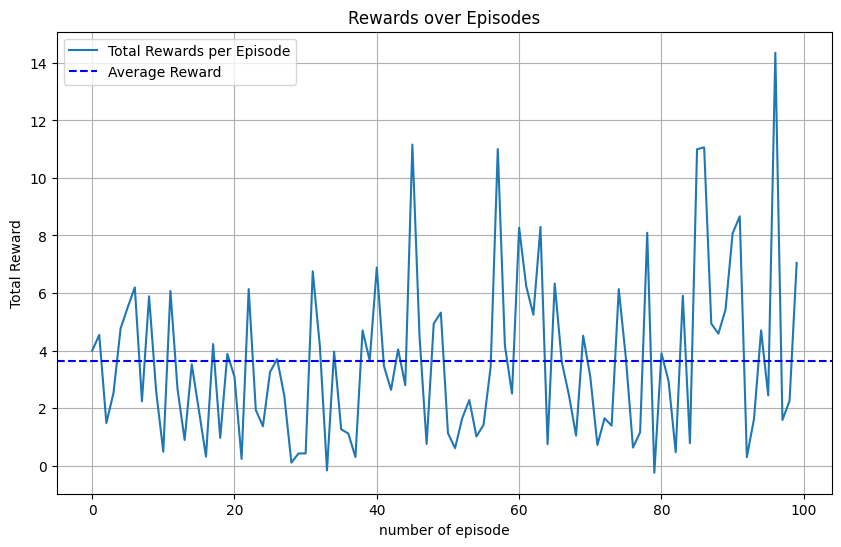

The overall average rewards obtained from the baseline PPO is :3.642671948543866


In [77]:
rewards=evaluation(model_=model_baselinePPO,env_=env_baselinePPO,num_episodes=100)
print(f'The overall average rewards obtained from the baseline PPO is :{np.mean(rewards)}')

In [78]:
#evaluate_policy(model_baselinePPO, env_baselinePPO, n_eval_episodes=100, render=False)

In [79]:
env_baselinePPO.close()

## PPO First improvement

In [80]:
#Gymnasium environment wrapper around Grid2Op environment
class PPO_nd_improve(gym.Env):
    def __init__(
            self,env_config: Dict[Literal["backend_cls",
                                          "backend_options",
                                          "env_name",
                                          "env_is_test",
                                          "obs_attr_to_keep",
                                          "act_type",
                                          "act_attr_to_keep"],
                                  Any] = None):
        super().__init__()
        if env_config is None:
            self.env_config = {}
        else:
            self.env_config=env_config

        backend_cls = LightSimBackend
        if "backend_cls" in self.env_config:
            backend_cls = self.env_config["backend_cls"]
        backend_options = {}
        if "backend_options" in self.env_config:
            backend_options = self.env_config["backend_options"]
        self._backend = backend_cls(**backend_options)

        #self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward  # Setup further below

        # DO NOT CHANGE Parameters
        # See https://grid2op.readthedocs.io/en/latest/parameters.html
        p = Parameters()
        p.MAX_SUB_CHANGED = 4  # Up to 4 substations can be reconfigured each timestep
        p.MAX_LINE_STATUS_CHANGED = 4  # Up to 4 powerline statuses can be changed each timestep

        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        ##########
        # REWARD #
        ##########
        # NOTE: This reward should not be modified when evaluating RL agent
        # See https://grid2op.readthedocs.io/en/latest/reward.html
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        # reward = N1 + L2RPN
        cr.initialize(self._g2op_env)
        ##########

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

        self.observation_space = self.setup_observations()
        self.action_space = self.setup_actions()

    def setup_observations(self):
        #print("WARNING: setup_actions is not doing anything. Implement your own code in this method.")
        obs_attr_to_keep = ["rho", "p_or", "gen_p", "load_p"]
        if "obs_attr_to_keep" in self.env_config:
            obs_attr_to_keep = copy.deepcopy(self.env_config["obs_attr_to_keep"])
        self._gym_env.observation_space.close()
        self._gym_env.observation_space = BoxGymObsSpace(self._g2op_env.observation_space,
                                                         attr_to_keep=obs_attr_to_keep
                                                         )
        # export observation space for the Grid2opEnv
        observation_space = Box(shape=self._gym_env.observation_space.shape,
                                     low=self._gym_env.observation_space.low,
                                     high=self._gym_env.observation_space.high)
        return observation_space

    def setup_actions(self):
        action_space=self._gym_env.action_space
        # for distcrete action type
        act_attr_to_keep =  ["set_line_status","redispatch","set_bus"]
        if "act_attr_to_keep" in self.env_config:
            act_attr_to_keep = copy.deepcopy(self.env_config["act_attr_to_keep"])
        self._gym_env.action_space = DiscreteActSpace(self._g2op_env.action_space,
                                                      attr_to_keep=act_attr_to_keep)
        action_space = Discrete(self._gym_env.action_space.n)
        return action_space

    def reset(self, seed=None):
        return self._gym_env.reset(seed=seed, options=None)

    def step(self, action):
        return self._gym_env.step(action)

    def render(self):
        # TODO: Modify for your own required usage
        return self._gym_env.render()

In [81]:
def custom_evaluation(model,env,n_eval_episodes=10,deterministic=True):

    # Wrap environment in a DummyVecEnv if it’s a single instance
    if not isinstance(env, VecEnv):
        env = DummyVecEnv([lambda: env])

    rewards_per_episode = []
    observations = env.reset()
    states = None  # For recurrent policies
    episode_starts = np.ones(env.num_envs, dtype=bool)
    episode_rewards = np.zeros(env.num_envs)
    episode_counts = np.zeros(env.num_envs, dtype=int)

    while sum(episode_counts) < n_eval_episodes:
        actions, states = model.predict(observations, state=states, deterministic=deterministic)
        new_observations, rewards, dones, infos = env.step(actions)

        episode_rewards += rewards
        for i in range(env.num_envs):
            if dones[i]:
                rewards_per_episode.append(episode_rewards[i])
                episode_rewards[i] = 0
                episode_counts[i] += 1

        observations = new_observations
    plt.figure(figsize=(10, 6))
    plt.plot(rewards_per_episode, label='Total Rewards per Episode')
    plt.title('Rewards over Episodes')
    plt.xlabel('number of episode')
    plt.ylabel('Total Reward')
    #plt.axhline(y=rewards_per_episode, color='b', linestyle='--', label='Average Reward')
    plt.legend()
    plt.grid()
    plt.show()

    return rewards_per_episode[:n_eval_episodes]

In [82]:
wandb.login()

True

In [83]:
# run this see the characteristics of the algorithm when learning, else just run the cell below this 
config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 20000,
    "env_name": "l2rpn_case14_sandbox",
}
run = wandb.init(
    project="rl project",
    config=config,
    sync_tensorboard=True,  # auto-upload rl project's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


def make_env():
    env = PPO_nd_improve()
    env = Monitor(env)  # record stats such as returns
    return env


env_PPO_nd_improve  = DummyVecEnv([make_env])

model_PPO_nd_improve= PPO(config["policy_type"], env_PPO_nd_improve , verbose=1, tensorboard_log=f"runs/{run.id}")
model_PPO_nd_improve.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(
        gradient_save_freq=1,
        model_save_path=f"models/{run.id}",
        verbose=2,
    ),
)
run.finish()

/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Logging to runs/0wmyjuq0/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.55     |
|    ep_rew_mean     | 0.136    |
| time/              |          |
|    fps             | 18       |
|    iterations      | 1        |
|    time_elapsed    | 113      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.32        |
|    ep_rew_mean          | 0.382       |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 2           |
|    time_elapsed         | 216         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.022019379 |
|    clip_fraction        | 0.398       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.74       |
|    explained_variance

global_step,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
rollout/ep_len_mean,▁▂▂▃▃▄▄▅▆█
rollout/ep_rew_mean,▁▂▂▃▃▄▄▅▆█
time/fps,▁▁▂▃▅▅▆▇▇█
train/approx_kl,██▅▆▆▃▅▁▅
train/clip_fraction,██▆█▆▄▄▁▄
train/clip_range,▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▁▂▃▄▅▆▇█
train/explained_variance,▁▇▇██▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁
train/loss,▁▂▃▂▃▆▅█▇


In [84]:
# #training the 2nd improvement PPO algorithm
# env_PPO_nd_improve= PPO_nd_improve()
# env_PPO_nd_improve = DummyVecEnv([lambda: env_PPO_nd_improve])
# model_PPO_nd_improve = PPO('MlpPolicy', env_PPO_nd_improve, verbose = 1)
# model_PPO_nd_improve.learn(total_timesteps=20000)


# Save the model
ndPPO_path = '/kaggle/working/ndPPO_model.zip'
model_PPO_nd_improve.save(ndPPO_path)

del model_PPO_nd_improve

In [85]:
# reload the model the nd improved PPO model
model_PPO_nd_improve = PPO.load(ndPPO_path, env=env_PPO_nd_improve)

/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_locati

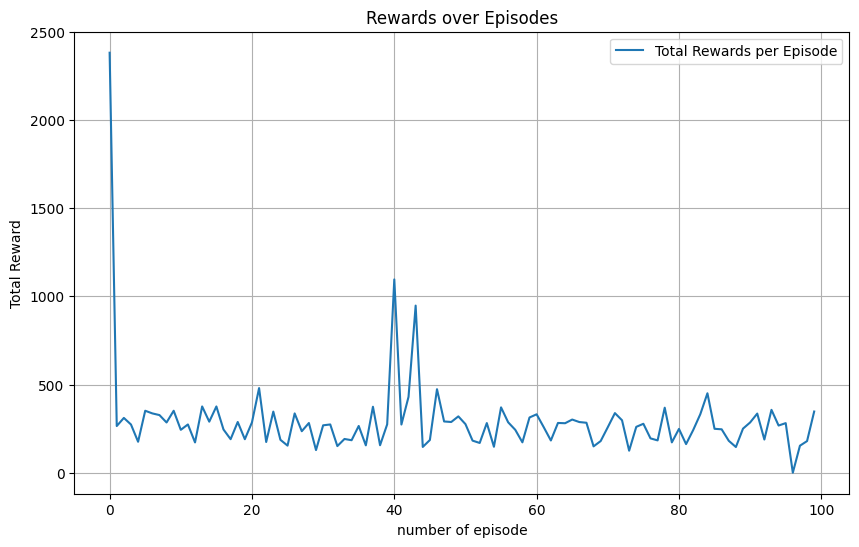

The overall average rewards obtained from first PPO improvement is :294.06792747884987


In [86]:
#evaluate_policy(model_PPO_nd_improve, env_PPO_nd_improve, n_eval_episodes=100, render=False)
ave_rewards=custom_evaluation(model=model_PPO_nd_improve,env=env_PPO_nd_improve,n_eval_episodes=100)
ave_rewards
print(f'The overall average rewards obtained from first PPO improvement is :{np.mean(ave_rewards)}')

In [87]:
env_PPO_nd_improve.close()

## Second PPO Improvement

In [89]:
# Gymnasium environment wrapper around Grid2Op environment
class Gym2OpEnv_2nd(gym.Env):
    def __init__(
            self,env_config: Dict[Literal["backend_cls",
                                          "backend_options",
                                          "env_name",
                                          "env_is_test",
                                          "obs_attr_to_keep",
                                          "act_type",
                                          "act_attr_to_keep"],
                                  Any] = None):
        super().__init__()
        if env_config is None:
            self.env_config = {}
        else:
            self.env_config=env_config

        backend_cls = LightSimBackend
        if "backend_cls" in self.env_config:
            backend_cls = self.env_config["backend_cls"]
        backend_options = {}
        if "backend_options" in self.env_config:
            backend_options = self.env_config["backend_options"]
        self._backend = backend_cls(**backend_options)

        #self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward  # Setup further below

        # DO NOT CHANGE Parameters
        # See https://grid2op.readthedocs.io/en/latest/parameters.html
        p = Parameters()
        p.MAX_SUB_CHANGED = 4  # Up to 4 substations can be reconfigured each timestep
        p.MAX_LINE_STATUS_CHANGED = 4  # Up to 4 powerline statuses can be changed each timestep

        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        ##########
        # REWARD #
        ##########
        # NOTE: This reward should not be modified when evaluating RL agent
        # See https://grid2op.readthedocs.io/en/latest/reward.html
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        # reward = N1 + L2RPN
        cr.initialize(self._g2op_env)
        ##########

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

        self.observation_space = self.setup_observations()
        self.action_space = self.setup_actions()

    def setup_observations(self):
        #print("WARNING: setup_actions is not doing anything. Implement your own code in this method.")
        obs_attr_to_keep = ["rho", "p_or", "gen_p", "load_p"]
        if "obs_attr_to_keep" in self.env_config:
            obs_attr_to_keep = copy.deepcopy(self.env_config["obs_attr_to_keep"])
        self._gym_env.observation_space.close()
        self._gym_env.observation_space = BoxGymObsSpace(self._g2op_env.observation_space,
                                                         attr_to_keep=obs_attr_to_keep
                                                         )
        # export observation space for the Grid2opEnv
        observation_space = Box(shape=self._gym_env.observation_space.shape,
                                     low=self._gym_env.observation_space.low,
                                     high=self._gym_env.observation_space.high)
        return observation_space

    def setup_actions(self):
        action_space=self._gym_env.action_space
        # for distcrete action type
        act_attr_to_keep =  ["set_line_status","redispatch","set_bus"]
        if "act_attr_to_keep" in self.env_config:
            act_attr_to_keep = copy.deepcopy(self.env_config["act_attr_to_keep"])
        self._gym_env.action_space = DiscreteActSpace(self._g2op_env.action_space,
                                                      attr_to_keep=act_attr_to_keep)
        action_space = Discrete(self._gym_env.action_space.n)
        return action_space

    def reset(self, seed=None):
        return self._gym_env.reset(seed=seed, options=None)

    def step(self, action):
        obs, reward, terminated, truncated, info = self._gym_env.step(action)

        # Reward shaping based on action types
        if not terminated:
            reward += 0.1

        # Define action categories
        if action in range(0, 50):

            reward += 0.2
        elif action in range(50, 150):

            reward += 0.3
        elif action in range(150, 315):

            reward += 0.1
        else:
            reward -= 0.1

        if info.get("is_illegal", False):
            reward -= 2.0

        if "rho" in obs and any(r > 1 for r in obs["rho"]):
            reward -= 0.5

        return obs, reward, terminated, truncated,info

    def render(self):
        # TODO: Modify for your own required usage
        return self._gym_env.render()

In [90]:
wandb.login()

True

In [91]:
# run this see the characteristics of the algorithm when learning, else just run the cell below this 
config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 20000,
    "env_name": "l2rpn_case14_sandbox",
}
run = wandb.init(
    project="rl project",
    config=config,
    sync_tensorboard=True,  # auto-upload rl project's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


def make_env():
    env = Gym2OpEnv_2nd()
    env = Monitor(env)  # record stats such as returns
    return env


env_PPO_rd   = DummyVecEnv([make_env])

model_PPO_rd = PPO(config["policy_type"],env_PPO_rd  , verbose=1, tensorboard_log=f"runs/{run.id}")
model_PPO_rd.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(
        gradient_save_freq=1,
        model_save_path=f"models/{run.id}",
        verbose=2,
    ),
)
run.finish()

/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Logging to runs/tv3lzrid/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.41     |
|    ep_rew_mean     | 0.989    |
| time/              |          |
|    fps             | 19       |
|    iterations      | 1        |
|    time_elapsed    | 106      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.97        |
|    ep_rew_mean          | 1.13        |
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 2           |
|    time_elapsed         | 211         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020664927 |
|    clip_fraction        | 0.434       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.74       |
|    explained_variance

global_step,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
rollout/ep_len_mean,▁▂▂▃▃▅▅▇▇█
rollout/ep_rew_mean,▁▁▂▂▃▅▅▇██
time/fps,▁▁▂▂▃▅▆▆▇█
train/approx_kl,██▆▆█▄▄▃▁
train/clip_fraction,█▇▆▅▆▄▅▄▁
train/clip_range,▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▂▂▃▄▅▆▇█
train/explained_variance,▁▇▆▇▇██▇▇
train/learning_rate,▁▁▁▁▁▁▁▁▁
train/loss,▁▁▂▂▃▂█▇█


In [92]:
# #training the rd improvement PPO algorithm
# env_PPO_rd = Gym2OpEnv_2nd()
# env_PPO_rd = DummyVecEnv([lambda: env_PPO_rd])
# model_PPO_rd = PPO('MlpPolicy', env_PPO_rd, verbose = 1)

# model_PPO_rd.learn(total_timesteps=20000)


# Save the model
rdPPO_path = '/kaggle/working/rdPPO_model.zip'
model_PPO_rd.save(rdPPO_path)

del model_PPO_rd

In [93]:
# # Save the model
# rdPPO_path = '/kaggle/working/rdPPO_model.zip'
# model_PPO_rd.save(rdPPO_path)

# del model_PPO_rd

In [94]:
# reload the model the nd improved PPO model
model_PPO_rd = PPO.load(rdPPO_path, env=env_PPO_rd)

/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_locati

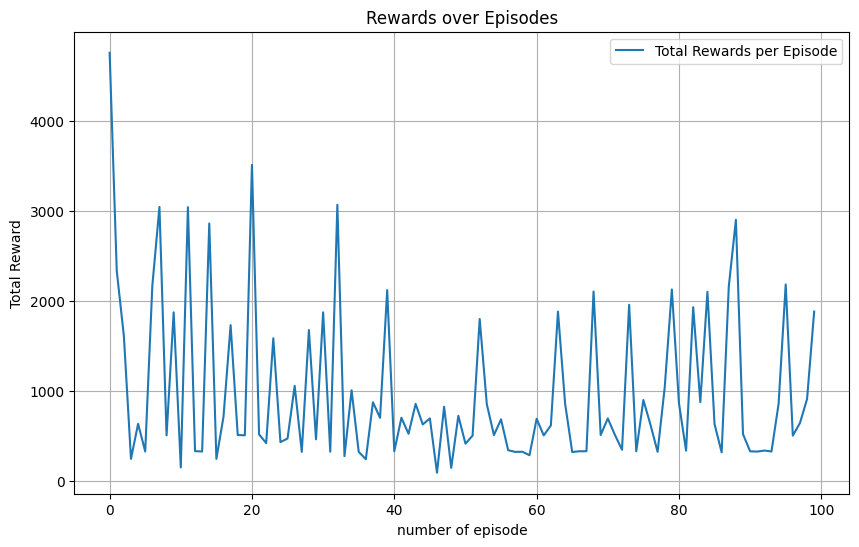

The overall average rewards obtained from second PPO improvement is :989.6266890610755


In [95]:

averd_rewards=custom_evaluation(model=model_PPO_rd,env=env_PPO_rd,n_eval_episodes=100)
averd_rewards
print(f'The overall average rewards obtained from second PPO improvement is :{np.mean(averd_rewards)}')

In [96]:
#evaluation(model_=model_PPO_rd,env_=env_PPO_rd,num_episodes=100)
#evaluate_policy(model_PPO_rd, env_PPO_rd, n_eval_episodes=100, render=False)

In [97]:
env_PPO_rd.close()